In [1]:
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import datetime
import requests
import numpy as np
import pandas as pd
!pip install yfinance
import yfinance as yf

In [2]:
#Creat a function to calucalte stock/market return caompare value with previuos one
def Return_Rate(x,y,z):
  x = x.rename(columns = {"Adj Close": y})
  x["Date"] = pd.to_datetime(x["Date"])
  x[y] = pd.to_numeric(x[y])
  x["REF"] = x[y].shift(periods=1)
  x[z] = (x[y]-x["REF"])/x["REF"]
  x = x.dropna()
  x = x[["Index", "Date",y,"REF", z]]
  return x

In [3]:
# Create a function to calculate the market/stock premium
# by taking the market/stock return and subtracting the risk free return
# Manipulating the data to fit our format by renaming columns
def Premium_with_risk_free(x, y, z, a):
  x = pd.merge(y, Risk_Free, on = "Date")
  x[z] = x[a]- x["Risk-Free Return"]
  x[z] = pd.to_numeric(x[z])
  x["Compound Rate_0"] = (1+x[z])
  x["Compound Rate"] = x["Compound Rate_0"].cumprod()
  x["Investment"] = 1000*["Compound Rate"]
  x = x[["Date", "Risk-Free Return", z, "Compound Rate_0","Compound Rate", "Investment"]]
  x = x.rename(columns = {"Date_y":"Date"})
  return x

In [34]:
#History Data Time Frame
Startdate = "2003-01-01"
Enddate = "2023-01-02"

Startdate = pd.to_datetime(Startdate)
Enddate = pd.to_datetime(Enddate)

In [5]:
#Risk-Free rate taken as Treasury bond from Yahoo Finance: 13 Week Treasury Bill: ^IRX, 	Treasury Yield 5 Years: ^FVX, Treasury Yield 10 Years: ^TNX, Treasury Yield 30 Years: ^TYX
TB10 = yf.download("^TNX",start=Startdate,end=Enddate, interval='1mo')
TB10.insert(0, "Index", range(1, 1 + len(TB10)))

[*********************100%%**********************]  1 of 1 completed


In [6]:
TB30 = yf.download("^TYX",start=Startdate,end=Enddate, interval='1mo')
TB30.insert(0, "Index", range(1, 1 + len(TB30)))

[*********************100%%**********************]  1 of 1 completed


In [7]:
Risk_Free = TB10
Risk_Free = Risk_Free.reset_index(drop=False)

Risk_Free.tail()

,Date,Index,Open,High,Low,Close,Adj Close,Volume
236,2022-09-01,237,3.217,3.992,3.176,3.804,3.804,0
237,2022-10-01,238,3.712,4.333,3.564,4.077,4.077,0
238,2022-11-01,239,3.937,4.223,3.668,3.703,3.703,0
239,2022-12-01,240,3.594,3.905,3.402,3.879,3.879,0
240,2023-01-01,241,3.758,3.810,3.373,3.529,3.529,0


In [8]:
#Calcuate risk free return for each month
Risk_Free = Risk_Free.rename(columns = {"Adj Close":"TB"})
Risk_Free["Date"] = pd.to_datetime(Risk_Free["Date"])
Risk_Free["TB"] = pd.to_numeric(Risk_Free["TB"])
Risk_Free["Risk-Free Return"] = Risk_Free["TB"]/100
Risk_Free = Risk_Free.dropna()
Risk_Free = Risk_Free[["Index", "Date", "TB", "Risk-Free Return"]]
Risk_Free.tail(3)

,Index,Date,TB,Risk-Free Return
238,239,2022-11-01,3.703,0.03703
239,240,2022-12-01,3.879,0.03879
240,241,2023-01-01,3.529,0.03529


In [9]:
def Premium(x, y, z, a):
  x = pd.merge(y, Risk_Free, on = "Date")
  x[z] = x[a]
  x[z] = pd.to_numeric(x[z])
  x["Compound Rate_0"] = (1+x[z])
  x["Compound Rate"] = x["Compound Rate_0"].cumprod()
  x["Compound Rate"] = pd.to_numeric(x["Compound Rate"])

  x = x[["Date", z, "Compound Rate"]]
  x = x.rename(columns = {"Date_y":"Date"})
  return x

In [10]:
def Compound_Rate(asset_name):
    asset_data = yf.download(asset_name, start=Startdate, end=Enddate, interval='1mo')
    asset_data.insert(0, "Index", range(1, 1 + len(asset_data)))
    asset_data = asset_data.reset_index(drop=False)
    asset_data = Return_Rate(asset_data, "Stock Value", asset_name + " Return")
    asset_data = Premium(asset_name + '_Premium', asset_data, asset_name + ' Premium', asset_name + ' Return')
    return asset_data

In [11]:
Amazon = Compound_Rate('AMZN')

[*********************100%%**********************]  1 of 1 completed


In [12]:
SPY = Compound_Rate('SPY')

[*********************100%%**********************]  1 of 1 completed


In [17]:
NASDAQ = Compound_Rate('^IXIC')
Dow_Jones = Compound_Rate('^DJI')
SP_500 = Compound_Rate('^GSPC')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [18]:
NASDAQ["NASDAQ Invesment"] = NASDAQ["Compound Rate"]*1000
Dow_Jones["Dow_Jones Invesment"] = Dow_Jones["Compound Rate"]*1000
SP_500["SP_500 Invesment"] = SP_500["Compound Rate"]*1000


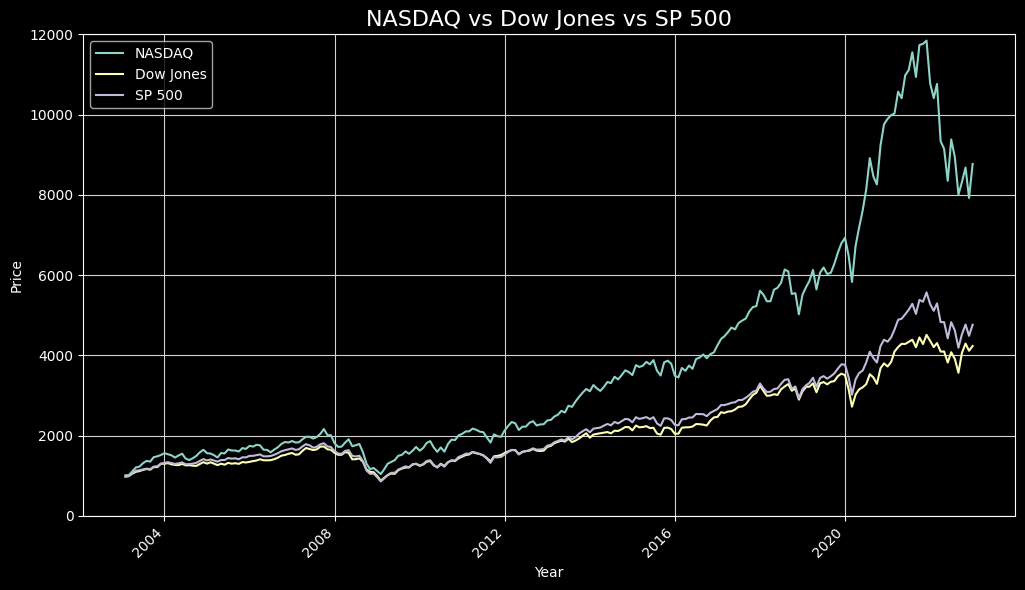

In [21]:
# Chart of cost of equity for each year for Amazon stock graphically represented from 2002 to 2022
fig, axes = plt.subplots(nrows = 1, ncols = 1)
fig.set_size_inches(12, 6)

axes.plot(NASDAQ["Date"], NASDAQ["NASDAQ Invesment"])
axes.plot(Dow_Jones["Date"], Dow_Jones["Dow_Jones Invesment"])
axes.plot(SP_500["Date"], SP_500["SP_500 Invesment"])

axes.set(title = "NASDAQ vs Dow Jones vs SP 500", xlabel = "Year", ylabel = "Price")
axes.title.set_size(16)
plt.grid(color = "lightgray")
fig.autofmt_xdate(rotation=45) #format x-axis as date, rotate 45 degrees
axes.set_ylim([0,12000])
#axes.set_facecolor('black') #make background behind grid whiteaxes[0].legend([Trade_Name +" Cost of Equity"] ,loc = 2) #move legend to right
fig.tight_layout() #use tight layout
axes.legend(["NASDAQ", "Dow Jones", "SP 500", "RSP"] ,loc = 2) #move legend to right
fig.subplots_adjust(right = .85) #adjust subplots to make legend fit, adjusted this a bit from smaller figure example!
axes.grid(color = "lightgray")
plt.show()

In [62]:
assets = ["SPY", "IVV", "VTI", "GLD", "XLV", "IWM"]


In [70]:
SPY = Compound_Rate('SPY')
IVV = Compound_Rate('IVV')
VTI = Compound_Rate('VTI')
GLD = Compound_Rate('GLD')
XLV = Compound_Rate('XLV')
IWM = Compound_Rate('IWM')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [71]:
SPY["SPY Invesment"] = SPY["Compound Rate"]*1000
IVV["IVV Invesment"] = IVV["Compound Rate"]*1000
VTI["VTI Invesment"] = VTI["Compound Rate"]*1000
GLD["GLD Invesment"] = GLD["Compound Rate"]*1000
XLV["XLV Invesment"] = XLV["Compound Rate"]*1000
IWM["IWM Invesment"] = IWM["Compound Rate"]*1000

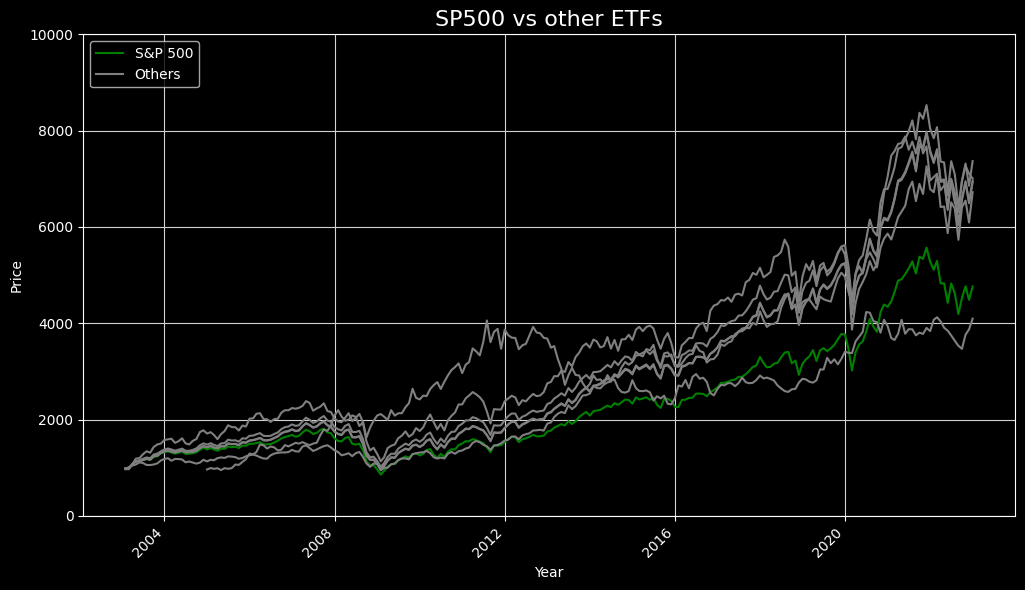

In [74]:
# Chart of cost of equity for each year for Amazon stock graphically represented from 2002 to 2022
fig, axes = plt.subplots(nrows = 1, ncols = 1)
fig.set_size_inches(12, 6)


axes.plot(SP_500["Date"], SP_500["SP_500 Invesment"], color = "green")

axes.plot(SPY["Date"], SPY["SPY Invesment"], color = "grey")
axes.plot(IVV["Date"], IVV["IVV Invesment"], color = "grey")
axes.plot(VTI["Date"], VTI["VTI Invesment"], color = "grey")
axes.plot(GLD["Date"], GLD["GLD Invesment"], color = "grey")
axes.plot(XLV["Date"], XLV["XLV Invesment"], color = "grey")
axes.plot(IWM["Date"], IWM["IWM Invesment"], color = "grey")



axes.set(title = "SP500 vs other ETFs", xlabel = "Year", ylabel = "Price")
axes.title.set_size(16)
plt.grid(color = "lightgray")
fig.autofmt_xdate(rotation=45) #format x-axis as date, rotate 45 degrees
axes.set_ylim([0,10000])
axes.set_facecolor('black') #make background behind grid whiteaxes[0].legend([Trade_Name +" Cost of Equity"] ,loc = 2) #move legend to right
fig.tight_layout() #use tight layout
axes.legend(["S&P 500", "Others"] ,loc = 2) #move legend to right

fig.subplots_adjust(right = .85) #adjust subplots to make legend fit, adjusted this a bit from smaller figure example!
axes.grid(color = "lightgray")
plt.show()